In [1]:
import numpy as np
import pprint
import astropy
from astropy.io import fits
from pathlib import Path
from matplotlib import pyplot as plt

In [2]:
wrapped_file = Path('/data/TRECS_Outputs/catalogue_continuum_wrapped.fits')
wrapped_file.resolve()

PosixPath('/data/TRECS_Outputs/catalogue_continuum_wrapped.fits')

In [3]:
print(f"{wrapped_file.stat().st_size / (1 << 30)} GB")

1.3446584343910217 GB


In [4]:
fits.info(wrapped_file)

Filename: /data/TRECS_Outputs/catalogue_continuum_wrapped.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  Catalogue     1 BinTableHDU    186   5917189R x 59C   [1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   


In [5]:
hdu = fits.open(wrapped_file)
hdu

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fa53b84d710>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fa53b869410>]

In [6]:
for h in hdu:
    pprint.pprint(h.header)

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  244 / width of table in bytes                        
NAXIS2  =              5917189 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                   

In [7]:
catalog = hdu[1].data
print(f"Number of point sources: {len(catalog):,}")

Number of point sources: 5,917,189


## 2D histogram of point source number distribution

In [8]:
x, y = catalog['x_coord'], catalog['y_coord']
x, y

(array([ 0.2618904,  3.756937 ,  1.7883625, ...,  3.3783913, -1.0254288,
         2.2807083], dtype=float32),
 array([ 1.6073284, -1.151001 ,  1.009634 , ..., -3.352581 , -2.3677616,
         3.8957195], dtype=float32))

In [9]:
# 'redshift', 'size'[arcsec], 'inclination'[deg] 'axis ratio', 'bmaj'[arcsec], 'bmin'[arcsec], 'PA'[deg]
z, s, incl, q, a, b, pa = catalog['redshift'], catalog['size'], catalog['inclination'], catalog['axis ratio'], catalog['bmaj'], catalog['bmin'], catalog['PA']
print(s)

[80.41321    61.542965   25.97571    ...  0.34984875  0.1769701
  0.12115891]


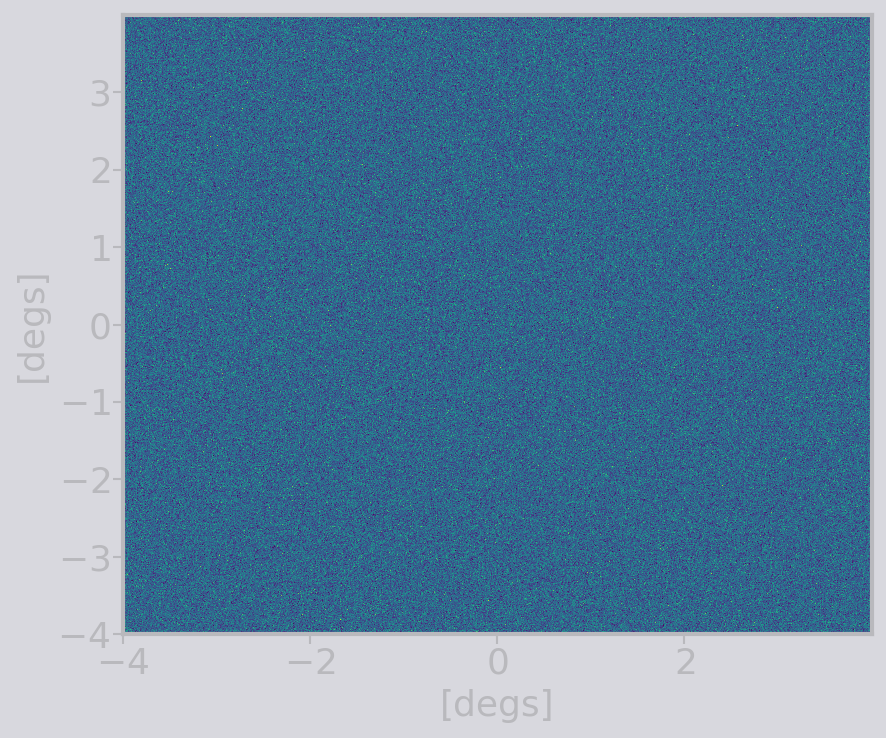

In [10]:
plt.figure(dpi=150)
# FOV is 8x8 deg: 800x800 bins -> 0.01 deg per bin
nbis = (800, 800)
plt.hist2d(x, y, bins=(800, 800))
plt.xlabel('[degs]')
plt.ylabel('[degs]')
plt.show()

## Plotting the total intensity flux densities

In [11]:
frequency_file = list(Path('..').rglob("frequency_list.dat"))[0]
frequency_file.resolve()

PosixPath('/home/phdenzel/TRECS/examples/frequency_list.dat')

In [12]:
frequencies = np.loadtxt(frequency_file)
frequencies

array([  150.,   325.,   408.,   610.,  1400.,  2100.,  3000.,  4800.,
        5500.,  9000., 15000., 18000., 20000.])

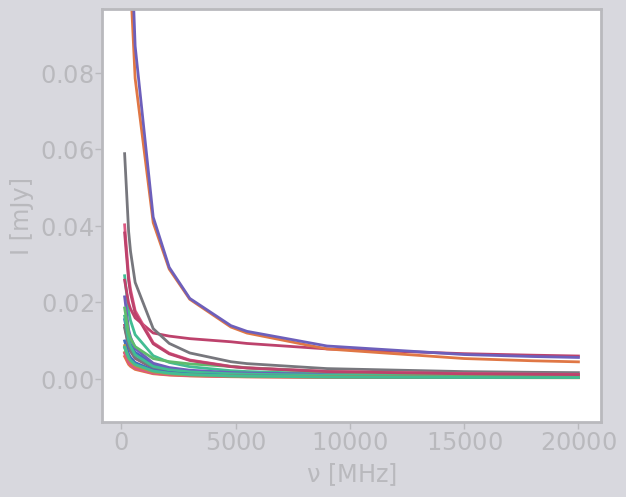

In [13]:
plt.figure(dpi=100)
random_idcs = np.random.choice(len(catalog), 20)
i150s = [f[3] for f in catalog[random_idcs]]
for i in random_idcs:
    plt.plot(frequencies, catalog[i][3:16])
plt.ylim(top=np.mean(i150s)+np.std(i150s))
plt.xlabel(r'$\nu$ [MHz]')
plt.ylabel('I [mJy]')
plt.show()

## Plotting the polarized flux densities

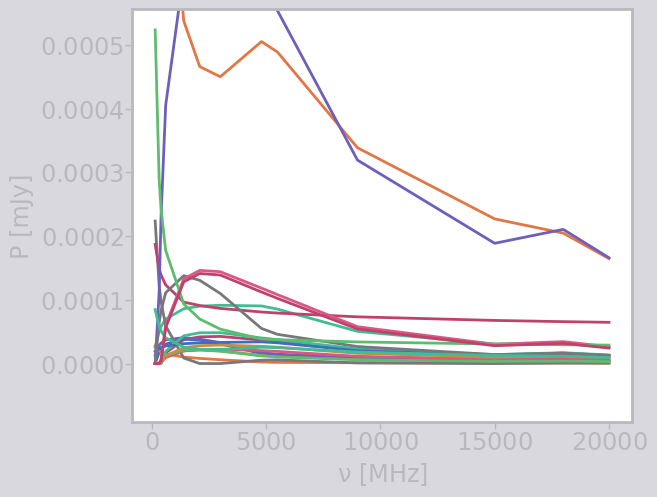

In [14]:
plt.figure(dpi=100)
p150s = [f[16] for f in catalog[random_idcs]]
for i in random_idcs:
    plt.plot(frequencies, catalog[i][16:29])
plt.ylim(top=np.mean(p150s)+np.std(p150s))
plt.xlabel(r'$\nu$ [MHz]')
plt.ylabel('P [mJy]')
plt.show() 